In [17]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
from skimage import io, color
import lightning.pytorch as pl
import matplotlib.pyplot as plt

%matplotlib inline

BATCH_SIZE = 32


class ImageColorizerDataset(Dataset):
    def __init__(
        self,
        root_dir,
        train=True,
        n_samples=1281167,
        transform=None,
        target_transform=None,
    ):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(
            os.path.join(root_dir, "train.csv" if train else "test.csv"),
            header=None,
        )
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = io.imread(image_path)
        lab_img = color.rgb2lab(rgb_img)

        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float(), ab.float()


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_data = ImageColorizerDataset(
    root_dir="./data",
    train=True,
    transform=transform,
    target_transform=transform,
    n_samples=1281167,
)
val_data = ImageColorizerDataset(
    root_dir="./data",
    train=False,
    transform=transform,
    target_transform=transform,
    n_samples=50000,
)

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
)
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
)


class Encoder(nn.Module):
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        act_fn: callable = nn.GELU,
    ):
        super().__init__()

        c_hid = base_channel_size

        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 64x64 -> 32x32
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 -> 16x16
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 -> 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 -> 4x4
            act_fn(),
        )

    def forward(self, x):
        x = self.net(x)
        return x


class Decoder(nn.Module):
    def __init__(
        self,
        num_output_channels: int,
        base_channel_size: int,
        act_fn: callable = nn.GELU,
    ):
        super().__init__()

        c_hid = base_channel_size

        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid,
                2 * c_hid,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),  # 4x4 -> 8x8
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * c_hid,
                2 * c_hid,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),  # 8x8 -> 16x16
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * c_hid,
                2 * c_hid,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),  # 16x16 -> 32x32
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * c_hid,
                c_hid,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),  # 32x32 -> 64x64
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_output_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.net(x)

        return x


class LitAutoEncoder(pl.LightningModule):
    def __init__(
        self,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        base_channel_size: int = 32,
        num_input_channels: int = 1,
        num_output_channels: int = 2,
        act_fn: callable = nn.GELU,
        width: int = 64,
        height: int = 64,
    ):
        super().__init__()
        self.encoder = encoder_class(
            num_input_channels=num_input_channels,
            base_channel_size=base_channel_size,
            act_fn=act_fn,
        )
        self.decoder = decoder_class(
            num_output_channels=num_output_channels,
            base_channel_size=base_channel_size,
            act_fn=act_fn,
        )

    def _get_loss(self, batch):
        l, ab = batch
        ab_hat = self.encoder(l)
        ab_hat = self.decoder(ab_hat)
        loss = F.mse_loss(ab_hat, ab)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

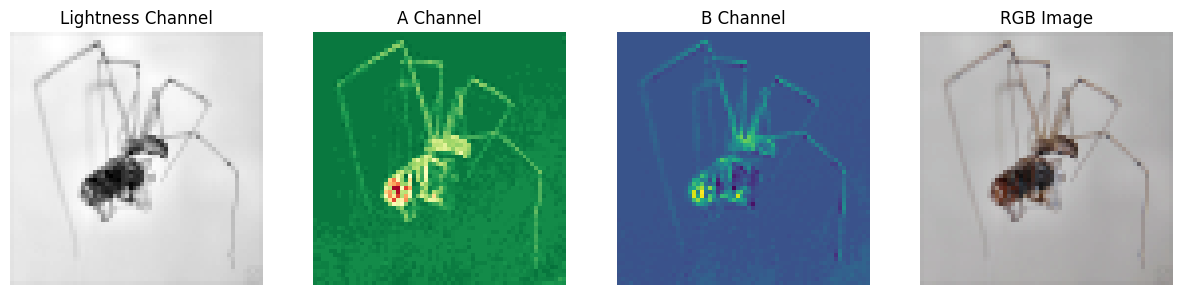

In [9]:
l, ab = next(iter(train_dataloader))

rgb_mean = read_image(os.path.join("./data", "mean.png")).permute(1, 2, 0).numpy() / 255.0
rgb_stdev = read_image(os.path.join("./data", "stdev.png")).permute(1, 2, 0).numpy() / 255.0

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(l[0].squeeze(), cmap="gray")
ax[0].set_title("Lightness Channel")
ax[0].set_axis_off()

ax[1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[1].set_title("A Channel")
ax[1].set_axis_off()

ax[2].imshow(ab[0, 1])
ax[2].set_title("B Channel")
ax[2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[3].imshow(rgb, interpolation=None)
ax[3].set_title("RGB Image")
ax[3].set_axis_off()

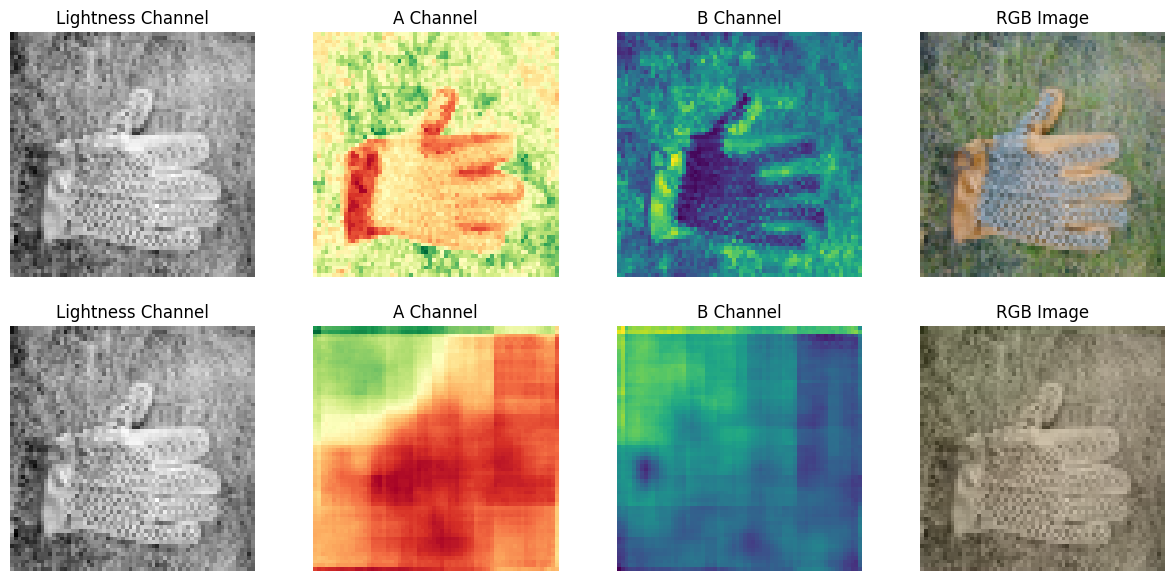

In [36]:
model = LitAutoEncoder.load_from_checkpoint(checkpoint_path="./model-2-final.ckpt")
model.eval()

l, ab = next(iter(val_dataloader))
ab_hat = model(l)

fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(l[0].squeeze(), cmap="gray")
ax[0, 0].set_title("Lightness Channel")
ax[0, 0].set_axis_off()

ax[0, 1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[0, 1].set_title("A Channel")
ax[0, 1].set_axis_off()

ax[0, 2].imshow(ab[0, 1])
ax[0, 2].set_title("B Channel")
ax[0, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[0, 3].imshow(rgb, interpolation=None)
ax[0, 3].set_title("RGB Image")
ax[0, 3].set_axis_off()

ax[1, 0].imshow(l[0].squeeze(), cmap="gray")
ax[1, 0].set_title("Lightness Channel")
ax[1, 0].set_axis_off()

ax[1, 1].imshow(ab_hat[0,0].detach().numpy(), cmap="RdYlGn_r")
ax[1, 1].set_title("A Channel")
ax[1, 1].set_axis_off()

ax[1, 2].imshow(ab_hat[0, 1].detach().numpy())
ax[1, 2].set_title("B Channel")
ax[1, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab_hat[0].detach().numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[1, 3].imshow(rgb, interpolation=None)
ax[1, 3].set_title("RGB Image")
ax[1, 3].set_axis_off()